# ARIMA univariate time series For All Datasets

Train size: 21024, Test size: 2628

ADF Test: Train Set - Scaled Solar Radiation (GHI)
ADF Statistic: -5.222479
p-value: 0.000008
Critical Value (1%): -3.431
Critical Value (5%): -2.862
Critical Value (10%): -2.567
Series is stationary. Proceeding with d=0 as specified.

Fitting SARIMA model manually with specified parameters. This may take a while...

SARIMA model fitting completed in 47.99 seconds.
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                21024
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 24)   Log Likelihood               28022.813
Date:                              Wed, 06 Nov 2024   AIC                         -56037.626
Time:                                      14:19:07   BIC                         -56005.822
Sample:                                           0   HQIC                        -56027.245
                                      

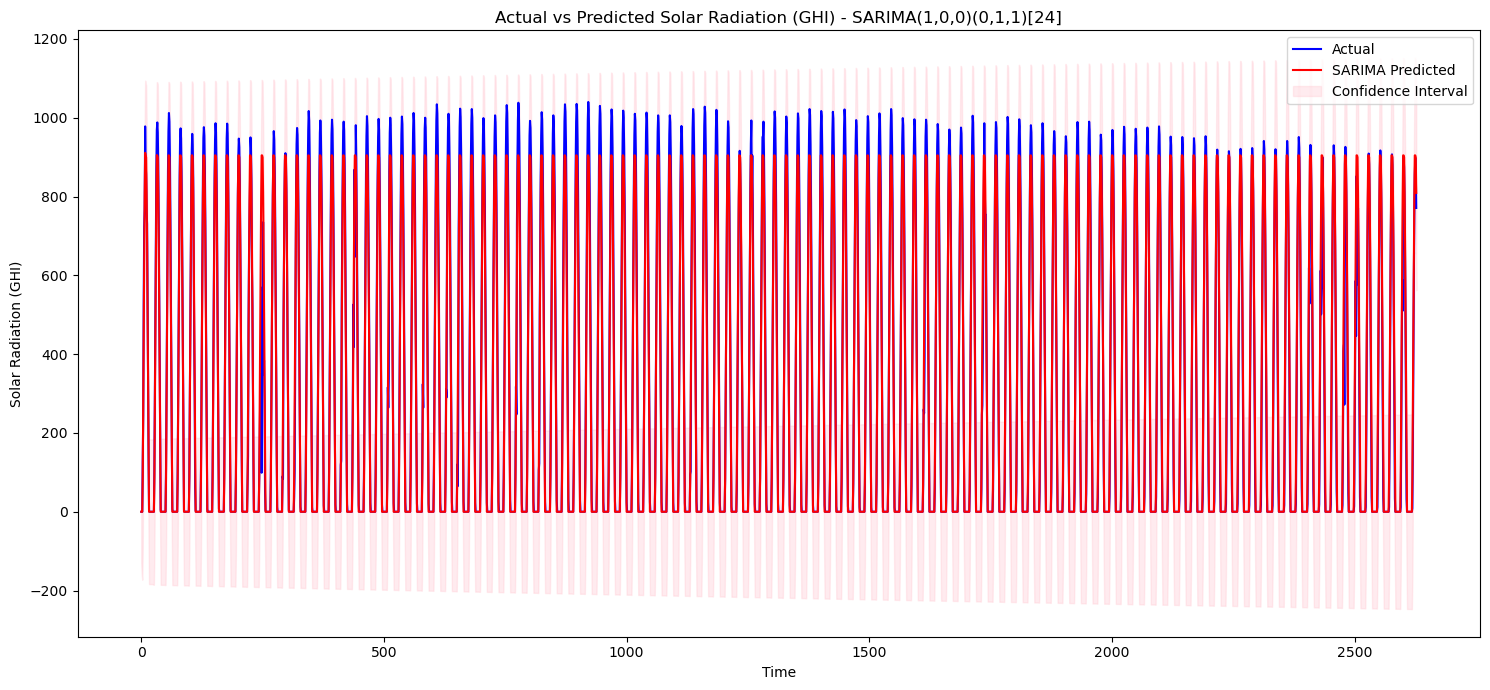

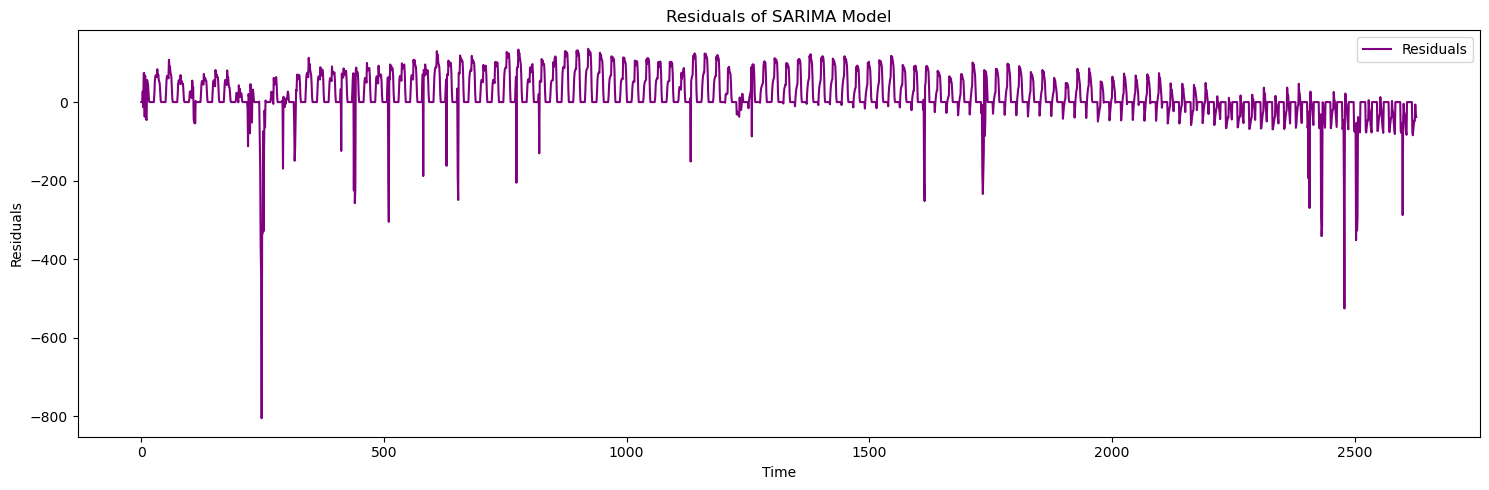

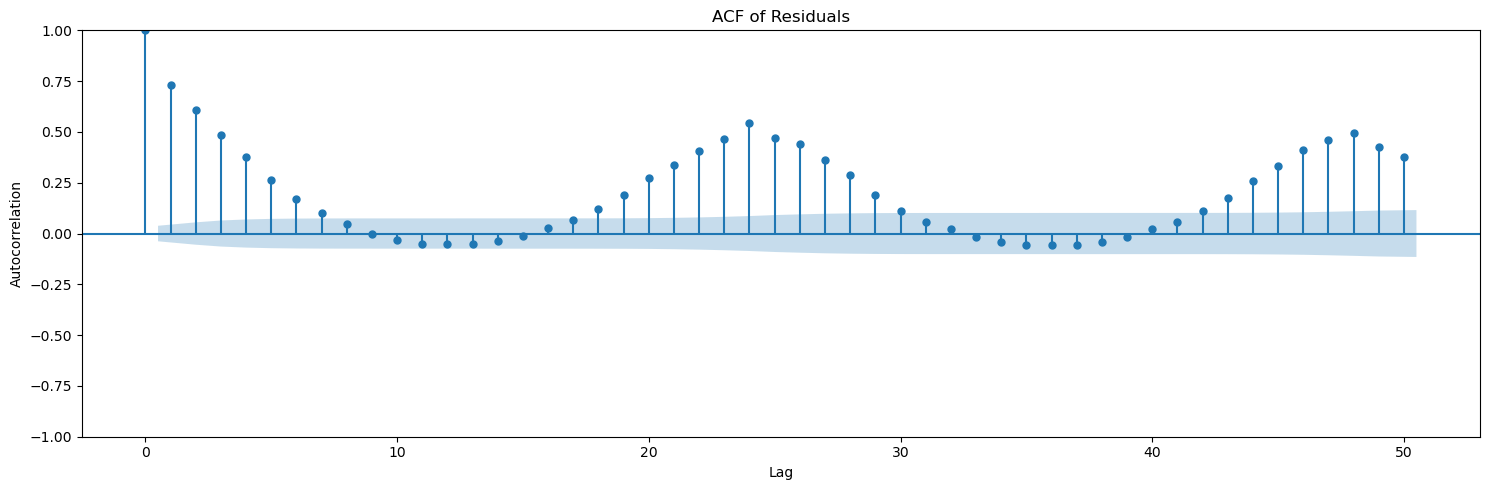

In [5]:
import numpy as np
import pandas as pd
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
import matplotlib.pyplot as plt  # Optional: For visualization
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # Optional: For ACF/PACF plots

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# 1. Load and Preprocess the Dataset
#Replace 'Palestine-PV.csv' with your actual dataset path
#data = pd.read_csv('jordan_pv.csv', parse_dates=['date'], infer_datetime_format=True, index_col='date')
data = pd.read_csv('Palestine-PV.csv', parse_dates=['date'], infer_datetime_format=True, index_col='date')

# Ensure the index is datetime
data.index = pd.to_datetime(data.index)

# Sort the DataFrame by the index (date) in ascending order to ensure chronological order
data = data.sort_index()

# Define target column
target_col = 'Solar Radiation(GHI)'

# Verify that the target column exists
if target_col not in data.columns:
    raise ValueError(f"'{target_col}' column not found in the dataset. Available columns: {list(data.columns)}")

# Select the target variable
target = data[target_col]

# Remove NaN values
target = target.dropna()

# Convert to float32 for efficiency
target = target.astype('float32')

# Convert to numpy array and flatten to 1D array for ARIMA
target = target.values.flatten()

# 2. Split into Train and Test Sets (20% Train, 5% Test) to Reduce Memory Consumption
train_size = int(len(target) * 0.80)
test_size = int(len(target) * 0.1)

# Ensure that train_size + test_size does not exceed the dataset length
if train_size + test_size > len(target):
    raise ValueError("Train size and test size exceed the total dataset length.")

# Perform the split
train, test = target[:train_size], target[train_size:train_size + test_size]

print(f"Train size: {train.shape[0]}, Test size: {test.shape[0]}")

# 3. Normalize the Data Using Only the Training Set
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the training data
train_scaled = scaler.fit_transform(train.reshape(-1, 1)).flatten()

# Transform the test data
test_scaled = scaler.transform(test.reshape(-1, 1)).flatten()

# Optional: Free up memory by deleting large objects
del data, target
import gc
gc.collect()

# 4. Ensure Stationarity with Augmented Dickey-Fuller (ADF) Test
def check_stationarity(timeseries, title=''):
    """
    Perform Augmented Dickey-Fuller test and print the results.
    Returns the p-value of the test.
    """
    print(f'\nADF Test: {title}')
    result = adfuller(timeseries, autolag='AIC')
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    for key, value in result[4].items():
        print(f'Critical Value ({key}): {value:.3f}')
    return result[1]

# Perform ADF Test on Train Set - Scaled Target
p_value = check_stationarity(train_scaled, title='Train Set - Scaled Solar Radiation (GHI)')

# Determine differencing order 'd' based on ADF test
# Since the model is SARIMA(1,0,0)(0,1,1)[24], we set d=0 and D=1
# However, it's good practice to verify stationarity
d = 0
if p_value > 0.05:
    print("Series is non-stationary. Although d=0 is specified, consider revisiting differencing.")
else:
    print("Series is stationary. Proceeding with d=0 as specified.")

# 5. Fit the SARIMA Model Manually Using statsmodels (Include Seasonality)
print("\nFitting SARIMA model manually with specified parameters. This may take a while...")
start_time_manual = time.time()

# Define SARIMAX parameters
# SARIMA(1,0,0)(0,1,1)[24]
p = 1 # AR order
d = 0  # Differencing order (as specified)
q = 0 # MA order

P = 1# Seasonal AR order
D = 1  # Seasonal differencing order
Q = 1 # Seasonal MA order
m = 24  # Seasonal period (e.g., hourly data with daily seasonality)

# Initialize and fit the SARIMAX model
sarima_model = SARIMAX(
    train_scaled,
    order=(p, d, q),
    seasonal_order=(P, D, Q, m),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_fit = sarima_model.fit(disp=False)
end_time_manual = time.time()
elapsed_time_manual = end_time_manual - start_time_manual
print(f"\nSARIMA model fitting completed in {elapsed_time_manual:.2f} seconds.")
print(sarima_fit.summary())

# 6. Forecasting with SARIMA
print("\nForecasting with SARIMA model...")
forecast_manual_scaled = sarima_fit.get_forecast(steps=test_size)
forecast_manual_scaled_mean = forecast_manual_scaled.predicted_mean
forecast_manual_conf_int = forecast_manual_scaled.conf_int()

# 7. Inverse Transform the Forecast and Test Data to Original Scale
# Remove '.values' as forecast_manual_scaled_mean is a numpy array
forecast_manual_unnorm = scaler.inverse_transform(forecast_manual_scaled_mean.reshape(-1, 1)).flatten()
test_unnorm = scaler.inverse_transform(test_scaled.reshape(-1, 1)).flatten()

# Inverse transform confidence intervals
conf_int_unnorm = scaler.inverse_transform(forecast_manual_conf_int)

# 8. Evaluation
# Calculate evaluation metrics on unnormalized data
mse_manual = mean_squared_error(test_unnorm, forecast_manual_unnorm)
rmse_manual = np.sqrt(mse_manual)
mae_manual = mean_absolute_error(test_unnorm, forecast_manual_unnorm)

# Calculate evaluation metrics on normalized data
mse_normalized_manual = mean_squared_error(test_scaled, forecast_manual_scaled_mean)
rmse_normalized_manual = np.sqrt(mse_normalized_manual)

# Calculate nRMSE (Normalized RMSE)
range_test = np.max(test_unnorm) - np.min(test_unnorm)
nrmse_manual = rmse_manual / range_test

print("\nSARIMA Model Evaluation Metrics:")
print(f"Mean Squared Error (MSE) on Test Set (Normalized): {mse_normalized_manual:.6f}")
print(f"Root Mean Squared Error (RMSE) on Test Set (Normalized): {rmse_normalized_manual:.6f}")
print(f"Mean Squared Error (MSE) on Test Set (Unnormalized): {mse_manual:.6f}")
print(f"Root Mean Squared Error (RMSE) on Test Set (Unnormalized): {rmse_manual:.6f}")
print(f"Mean Absolute Error (MAE) on Test Set (Unnormalized): {mae_manual:.6f}")
print(f"Normalized RMSE (nRMSE) on Test Set: {nrmse_manual:.6f}")

# 9. Implement Baseline Models

# A. Naive Forecast
print("\nImplementing Naive Forecast...")
# Shift the test set by one to create a naive forecast
naive_forecast_scaled = np.roll(test_scaled, 1)
naive_forecast_scaled[0] = train_scaled[-1]  # Set the first forecast to the last train value
naive_forecast_unnorm = scaler.inverse_transform(naive_forecast_scaled.reshape(-1, 1)).flatten()

# Calculate metrics for Naive Forecast
mse_naive = mean_squared_error(test_unnorm, naive_forecast_unnorm)
rmse_naive = np.sqrt(mse_naive)
mae_naive = mean_absolute_error(test_unnorm, naive_forecast_unnorm)
nrmse_naive = rmse_naive / range_test

print("\nNaive Forecast Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse_naive:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse_naive:.6f}")
print(f"Mean Absolute Error (MAE): {mae_naive:.6f}")
print(f"Normalized RMSE (nRMSE): {nrmse_naive:.6f}")

# B. Mean Forecast
print("\nImplementing Mean Forecast...")
mean_train = np.mean(train)
mean_forecast = np.full_like(test_unnorm, mean_train)
mse_mean = mean_squared_error(test_unnorm, mean_forecast)
rmse_mean = np.sqrt(mse_mean)
mae_mean = mean_absolute_error(test_unnorm, mean_forecast)
nrmse_mean = rmse_mean / range_test

print("\nMean Forecast Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse_mean:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse_mean:.6f}")
print(f"Mean Absolute Error (MAE): {mae_mean:.6f}")
print(f"Normalized RMSE (nRMSE): {nrmse_mean:.6f}")

# 10. Residual Diagnostics

# Calculate residuals
residuals_manual = test_unnorm - forecast_manual_unnorm

# Residual Statistics
residual_mean_manual = np.mean(residuals_manual)
residual_std_manual = np.std(residuals_manual)

print("\nResiduals Statistics (SARIMA):")
print(f"Mean of Residuals: {residual_mean_manual:.6f}")
print(f"Standard Deviation of Residuals: {residual_std_manual:.6f}")

# Perform Ljung-Box test
lb_test_manual = acorr_ljungbox(residuals_manual, lags=[10], return_df=True)
print("\nLjung-Box Test on Residuals (SARIMA):")
print(lb_test_manual)

# Optional: Visualization
# Uncomment the following lines if you wish to visualize the results

# 1. Plot Actual vs Predicted with Confidence Intervals
plt.figure(figsize=(15, 7))
plt.plot(test_unnorm, label='Actual', color='blue')
plt.plot(forecast_manual_unnorm, label='SARIMA Predicted', color='red')
plt.fill_between(
    np.arange(len(forecast_manual_unnorm)),
    conf_int_unnorm[:, 0],
    conf_int_unnorm[:, 1],
    color='pink',
    alpha=0.3,
    label='Confidence Interval'
)
plt.title('Actual vs Predicted Solar Radiation (GHI) - SARIMA(1,0,0)(0,1,1)[24]')
plt.xlabel('Time')
plt.ylabel('Solar Radiation (GHI)')
plt.legend()
plt.tight_layout()
plt.savefig("Actual_vs_Predicted_SARIMA.jpeg", format='jpeg', dpi=300)
plt.show()

# 2. Plot Residuals
plt.figure(figsize=(15, 5))
plt.plot(residuals_manual, label='Residuals', color='purple')
plt.title('Residuals of SARIMA Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.tight_layout()
plt.show()

# 3. Plot ACF of Residuals
plt.figure(figsize=(15, 5))
plot_acf(residuals_manual, ax=plt.gca(), lags=50, alpha=0.05)
plt.title('ACF of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.tight_layout()
plt.show()


In [44]:
# Import necessary libraries
import numpy as np
import pandas as pd
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
import matplotlib.pyplot as plt  # Optional: For visualization
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # Optional: For ACF/PACF plots

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# 1. Install and Import pmdarima's auto_arima
try:
    from pmdarima import auto_arima
except ImportError:
    raise ImportError("pmdarima library is not installed. Install it using 'pip install pmdarima'.")

# 2. Load and Preprocess the Dataset
# Replace 'Palestine-PV.csv' with your actual dataset path
data = pd.read_csv('Palestine-PV.csv', parse_dates=['date'], infer_datetime_format=True, index_col='date')

# Ensure the index is datetime
data.index = pd.to_datetime(data.index)

# Sort the DataFrame by the index (date) in ascending order to ensure chronological order
data = data.sort_index()

# Define target and exogenous variable columns
target_col = 'Solar Radiation(GHI)'
exog_cols = ['Air Temperature', 'Dew Point', 'Relative Humidity', 'Wind Direction', 'Wind Speed']

# Verify that all required columns are present
missing_cols = [col for col in [target_col] + exog_cols if col not in data.columns]
if missing_cols:
    raise ValueError(f"Missing columns in the dataset: {missing_cols}")

# Select target and exogenous variables
target = data[target_col]
exog = data[exog_cols]

# Remove rows with any NaN values in target or exogenous variables
combined = pd.concat([target, exog], axis=1).dropna()
target = combined[target_col]
exog = combined[exog_cols]

# Convert to float32 for efficiency
target = target.astype('float32')
exog = exog.astype('float32')

# 3. Split into Train and Test Sets (40% Train, 10% Test) to Reduce Memory Consumption
train_size = int(len(target) * 0.80)
test_size = int(len(target) * 0.10)

# Ensure that train_size + test_size does not exceed the dataset length
if train_size + test_size > len(target):
    raise ValueError("Train size and test size exceed the total dataset length.")

# Perform the split
target_train, target_test = target[:train_size], target[train_size:train_size + test_size]
exog_train, exog_test = exog[:train_size], exog[train_size:train_size + test_size]

print(f"Train size: {target_train.shape[0]}, Test size: {target_test.shape[0]}")

# 4. Normalize the Data Using Only the Training Set
# Initialize separate scalers for target and exogenous variables
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaler_exog = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the target and exogenous variables
scaled_target_train = scaler_target.fit_transform(target_train.values.reshape(-1, 1)).flatten()
scaled_target_test = scaler_target.transform(target_test.values.reshape(-1, 1)).flatten()

scaled_exog_train = scaler_exog.fit_transform(exog_train.values)
scaled_exog_test = scaler_exog.transform(exog_test.values)

# Optional: Free up memory by deleting large objects
del data, combined, target
import gc
gc.collect()

# 5. Ensure Stationarity with Augmented Dickey-Fuller (ADF) Test
def check_stationarity(timeseries, title=''):
    """
    Perform Augmented Dickey-Fuller test and print the results.
    Returns the p-value of the test.
    """
    print(f'\nADF Test: {title}')
    result = adfuller(timeseries, autolag='AIC')
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    for key, value in result[4].items():
        print(f'Critical Value ({key}): {value:.3f}')
    return result[1]

# Perform ADF Test on Train Set - Scaled Target
p_value = check_stationarity(scaled_target_train, title='Train Set - Scaled Solar Radiation (GHI)')

# Determine differencing order 'd' based on ADF test
# Since we'll use auto_arima, we'll let it handle differencing
if p_value > 0.05:
    print("Series is non-stationary. Differencing will be applied automatically by auto_arima.")
else:
    print("Series is stationary. No differencing required.")

# 6. Fit the SARIMA Model Automatically Using auto_arima
print("\nFitting SARIMA model using auto_arima. This may take a while...")
start_time_auto = time.time()

# Define seasonal period (m). Assuming hourly data with daily seasonality:
# If your data frequency is different, adjust 'm' accordingly.
m = 24

# Fit auto_arima with exogenous variables
sarima_model_auto = auto_arima(
    scaled_target_train,
    exogenous=scaled_exog_train,
    seasonal=True,
    m=m,
    start_p=0, start_q=0,
    max_p=1, max_q=1,
    start_P=0, start_Q=0,
    max_P=1, max_Q=1,
    d=None, D=1,  # Let auto_arima determine 'd', set seasonal differencing 'D' to 1
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    n_jobs=-1  # Utilize all available cores
)

end_time_auto = time.time()
elapsed_time_auto = end_time_auto - start_time_auto
print(f"\nauto_arima model fitting completed in {elapsed_time_auto:.2f} seconds.")
print(sarima_model_auto.summary())

# 7. Forecasting with auto_arima
print("\nForecasting with auto_arima SARIMA model...")
forecast_auto_scaled, conf_int_auto_scaled = sarima_model_auto.predict(n_periods=test_size, exogenous=scaled_exog_test, return_conf_int=True)

# 8. Inverse Transform the Forecast and Test Data to Original Scale
forecast_auto_unnorm = scaler_target.inverse_transform(forecast_auto_scaled.reshape(-1, 1)).flatten()
test_unnorm = scaler_target.inverse_transform(scaled_target_test.reshape(-1, 1)).flatten()

# Inverse transform confidence intervals
conf_int_auto_unnorm = scaler_target.inverse_transform(conf_int_auto_scaled)

# 9. Evaluation
# Calculate evaluation metrics on unnormalized data
mse_auto = mean_squared_error(test_unnorm, forecast_auto_unnorm)
rmse_auto = np.sqrt(mse_auto)
mae_auto = mean_absolute_error(test_unnorm, forecast_auto_unnorm)

# Calculate evaluation metrics on normalized data
mse_normalized_auto = mean_squared_error(scaled_target_test, forecast_auto_scaled)
rmse_normalized_auto = np.sqrt(mse_normalized_auto)

# Calculate nRMSE (Normalized RMSE)
range_test = np.max(test_unnorm) - np.min(test_unnorm)
nrmse_auto = rmse_auto / range_test

print("\nauto_arima SARIMA Model Evaluation Metrics:")
print(f"Mean Squared Error (MSE) on Test Set (Normalized): {mse_normalized_auto:.6f}")
print(f"Root Mean Squared Error (RMSE) on Test Set (Normalized): {rmse_normalized_auto:.6f}")
print(f"Mean Squared Error (MSE) on Test Set (Unnormalized): {mse_auto:.6f}")
print(f"Root Mean Squared Error (RMSE) on Test Set (Unnormalized): {rmse_auto:.6f}")
print(f"Mean Absolute Error (MAE) on Test Set (Unnormalized): {mae_auto:.6f}")
print(f"Normalized RMSE (nRMSE) on Test Set: {nrmse_auto:.6f}")

# 10. Implement Baseline Models

# A. Naive Forecast
print("\nImplementing Naive Forecast...")
# Shift the test set by one to create a naive forecast
naive_forecast_scaled = np.roll(scaled_target_test, 1)
naive_forecast_scaled[0] = scaled_target_train[-1]  # Set the first forecast to the last train value
naive_forecast_unnorm = scaler_target.inverse_transform(naive_forecast_scaled.reshape(-1, 1)).flatten()

# Calculate metrics for Naive Forecast
mse_naive = mean_squared_error(test_unnorm, naive_forecast_unnorm)
rmse_naive = np.sqrt(mse_naive)
mae_naive = mean_absolute_error(test_unnorm, naive_forecast_unnorm)
nrmse_naive = rmse_naive / range_test

print("\nNaive Forecast Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse_naive:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse_naive:.6f}")
print(f"Mean Absolute Error (MAE): {mae_naive:.6f}")
print(f"Normalized RMSE (nRMSE): {nrmse_naive:.6f}")

# B. Mean Forecast
print("\nImplementing Mean Forecast...")
mean_train = np.mean(target_train)
mean_forecast = np.full_like(test_unnorm, mean_train)
mse_mean = mean_squared_error(test_unnorm, mean_forecast)
rmse_mean = np.sqrt(mse_mean)
mae_mean = mean_absolute_error(test_unnorm, mean_forecast)
nrmse_mean = rmse_mean / range_test

print("\nMean Forecast Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse_mean:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse_mean:.6f}")
print(f"Mean Absolute Error (MAE): {mae_mean:.6f}")
print(f"Normalized RMSE (nRMSE): {nrmse_mean:.6f}")

# 11. Residual Diagnostics
print("\nPerforming Residual Diagnostics...")
residuals_auto = test_unnorm - forecast_auto_unnorm

# Residual Statistics
residual_mean_auto = np.mean(residuals_auto)
residual_std_auto = np.std(residuals_auto)

print("\nResiduals Statistics (auto_arima SARIMA):")
print(f"Mean of Residuals: {residual_mean_auto:.6f}")
print(f"Standard Deviation of Residuals: {residual_std_auto:.6f}")

# Perform Ljung-Box test
lb_test_auto = acorr_ljungbox(residuals_auto, lags=[10], return_df=True)
print("\nLjung-Box Test on Residuals (auto_arima SARIMA):")
print(lb_test_auto)

# 12. Optional: Visualization
# Uncomment the following lines if you wish to visualize the results

# Plot Actual vs Predicted with Confidence Intervals
plt.figure(figsize=(15, 7))
plt.plot(test_unnorm, label='Actual', color='blue')
plt.plot(forecast_auto_unnorm, label='auto_arima SARIMA Predicted', color='red')
plt.fill_between(
    np.arange(len(forecast_auto_unnorm)),
    conf_int_auto_unnorm[:, 0],
    conf_int_auto_unnorm[:, 1],
    color='pink',
    alpha=0.3,
    label='Confidence Interval'
)
plt.title('Actual vs Predicted Solar Radiation (GHI) - auto_arima SARIMA')
plt.xlabel('Time')
plt.ylabel('Solar Radiation (GHI)')
plt.legend()
plt.tight_layout()
plt.savefig("Actual_vs_Predicted_auto_arima_SARIMA.jpeg", format='jpeg', dpi=300)
plt.show()

# Plot Residuals
plt.figure(figsize=(15, 5))
plt.plot(residuals_auto, label='Residuals', color='purple')
plt.title('Residuals of auto_arima SARIMA Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.tight_layout()
plt.show()

# Plot ACF of Residuals
plt.figure(figsize=(15, 5))
plot_acf(residuals_auto, ax=plt.gca(), lags=50, alpha=0.05)
plt.title('ACF of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.tight_layout()
plt.show()


Train size: 21024, Test size: 2628

ADF Test: Train Set - Scaled Solar Radiation (GHI)
ADF Statistic: -5.222479
p-value: 0.000008
Critical Value (1%): -3.431
Critical Value (5%): -2.862
Critical Value (10%): -2.567
Series is stationary. No differencing required.

Fitting SARIMA model using auto_arima. This may take a while...
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=-34884.410, Time=22.95 sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=-49581.254, Time=201.52 sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=235.73 sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=-34886.335, Time=4.09 sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=-44852.436, Time=7.17 sec
 ARIMA(1,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=485.30 sec


KeyboardInterrupt: 